In [105]:
from csv import DictReader
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from nltk.stem.snowball import  SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
import re
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

Reading Data from Train and Test Files

In [106]:
def read_data(name):
    text, targets = [], []

    with open('data/{}.csv'.format(name)) as f:
        for item in DictReader(f):
            text.append(item['text'].decode('utf8'))
            targets.append(item['category'])

    return text, targets

Built function for preprocessing. Removal of stopwords for each line. Afterwards, usedSnowballStemmer to stem each of the individual  words in a given line.

In [107]:
def stem_words(line):
    stemmer=SnowballStemmer("english", ignore_stopwords=True)
    stop_words=set(stopwords.words('english'))
    line=line.split()
    words=""
    for i in line:
        if i not in stop_words:
            words=words+stemmer.stem(i)+" "
    return words

Built clean_str function to clean the strings with word contractions. Using regular expressions.

In [108]:
def clean_str(string):



    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\'m", " \'m", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

Baseline Model using Logistic Regression 

In [109]:
text_train, targets_train = read_data('train')
text_test, targets_test = read_data('test')
        
model = make_pipeline(
            TfidfVectorizer(),
            LogisticRegression(),
        ).fit(text_train, targets_train)
        
prediction = model.predict(text_test)
        
baseline = f1_score(targets_test, prediction, average='macro')
print 'macro f1:', baseline

macro f1: 0.323676828408


Applying the clean string function and stem function to each Whisper 
Also printing a small set of clean strings of Whispers

In [110]:
text_train=map(clean_str,text_train)
text_test=map(clean_str,text_test)

text_train=map(stem_words,text_train)
text_test=map(stem_words,text_test)

print text_train[0:20]

[u'look someon hold convers guy ', u'hey ', u'singl guy girl near spald ? femal ', u'white girl like ? ', u"n't feel enthusiast anyth life anymor realli suck ", u'swear god , husband suggest give dog away one time give away ', u'gay bi guy delhi ? ? ', u'someon road trip mall ', u'realli like hispan girl class thug girl ', u"bought puppi fix relationship 's still heroin addict ", u'someon stop way work ask number flatter yet terrifi moment life ', u"gonna mile 277 tonight see well hungarian line danc anyon wanna come 's gonna fun time 21m ", u'anybodi wanna talk ? extrem bore ', u"never date valentin 's day hate hear peopl complain ! 's realli big deal ", u'get guy valentin day ? ', u'need white chocol life ', u'english hello french bonjour spanish hola sup bitch ', u'im feel realli bad tonight ', u"'m 19 n't know meet girl want relationship advic ? ", u'mommi best ']


Applying Logistic Regression with changed parameter for min_df=20; Igonring terms with document freq less than 20

In [111]:
#Logistic Regression using Tfidf
model_tf = make_pipeline(TfidfVectorizer(max_df=0.95, min_df=20,
                                stop_words='english'),
        LogisticRegression(),
    ).fit(text_train, targets_train)

prediction = model_tf.predict(text_test)
score_logit = f1_score(targets_test, prediction, average='macro')
print 'macro f1 using TFIDF:', score_logit

macro f1 using TFIDF: 0.393336680879


Trying Logistic Regression with CountVectorizer instead of TFIDF, and min_df as 7 we can see some improvement in the model


In [112]:
#Logistic Regression using CountVectorizer
model_count = make_pipeline(CountVectorizer(max_df=0.95, min_df=7,
                                stop_words='english'),
        LogisticRegression(),
    ).fit(text_train, targets_train)

prediction = model_count.predict(text_test)

print 'macro f1 using CountVectorizer:', f1_score(targets_test, prediction, average='macro')

macro f1 using CountVectorizer: 0.483082746713


Multinomial Naive Bayes model for text classification. Trying out for different values of min_df. It seems to works best for min_df=30 for countvectorizer.

In [113]:
min=[5,10,20,30,40,50,60,65,70,75,80]
for n in min:
    model_NB = make_pipeline(CountVectorizer(max_df=0.95, min_df=n,
                                stop_words='english'),
        MultinomialNB(),
    ).fit(text_train, targets_train)

    prediction = model_NB.predict(text_test)

    print 'macro f1 using CountVectorizer:',n, f1_score(targets_test, prediction, average='macro')

macro f1 using CountVectorizer: 5 0.35282880051
macro f1 using CountVectorizer:

 10 0.368736090016
macro f1 using CountVectorizer:

 20 0.384899707225
macro f1 using CountVectorizer:

 30 0.397222581241
macro f1 using CountVectorizer:

 40 0.369767241368
macro f1 using CountVectorizer:

 50 0.351785534404
macro f1 using CountVectorizer:

 60 0.330865655264
macro f1 using CountVectorizer:

 65 0.328499181393
macro f1 using CountVectorizer:

 70 0.287506060653
macro f1 using CountVectorizer:

 75 0.283798853677
macro f1 using CountVectorizer:

 80 0.273991831072


Trying Naive Bayes with TFIDF

In [114]:
min=[5,10,20,30,40,50,60,65,70,75,80]
for n in min:
    model_NB = make_pipeline(TfidfVectorizer(max_df=0.95, min_df=n
                                         ,
                                stop_words='english'),
        MultinomialNB(),
    ).fit(text_train, targets_train)

    prediction = model_NB.predict(text_test)

    print 'macro f1 using TFIDFVectorizer:',n, f1_score(targets_test, prediction, average='macro')

macro f1 using TFIDFVectorizer: 5 0.147993473451
macro f1 using TFIDFVectorizer:

 10 0.160772178259
macro f1 using TFIDFVectorizer:

 20 0.188435513836
macro f1 using TFIDFVectorizer:

 30 0.202469326632
macro f1 using TFIDFVectorizer:

 40 0.213223046973
macro f1 using TFIDFVectorizer:

 50 0.219771729656
macro f1 using TFIDFVectorizer:

 60 0.226549371907
macro f1 using TFIDFVectorizer:

 65 0.226847082885
macro f1 using TFIDFVectorizer:

 70 0.199120890314
macro f1 using TFIDFVectorizer:

 75 0.194391932908
macro f1 using TFIDFVectorizer:

 80 0.193920631685


Random Forest Classifier using TFIDF and Count Vectorizer respectively

In [115]:
#Vectorizing Words
#Random Forest using TFIDF
vect= TfidfVectorizer(stop_words='english',min_df=6)
text_train_tf=vect.fit_transform(text_train)
text_test_tf=vect.transform(text_test)
rand_class=RandomForestClassifier()
rand_class.fit(text_train_tf,targets_train)
predi=rand_class.predict(text_test_tf)
print 'Random Forest:', f1_score(targets_test, predi, average='macro')

Random Forest: 0.373191943857


In [116]:
#Vectorizing Words
#Random Forest using CountVectorizer
vect2= CountVectorizer(stop_words='english',min_df=6)
text_train_cf=vect2.fit_transform(text_train)
text_test_cf=vect2.transform(text_test)
rand_class=RandomForestClassifier()
rand_class.fit(text_train_cf,targets_train)
predi=rand_class.predict(text_test_cf)
print 'Random Forest:', f1_score(targets_test, predi, average='macro')

Random Forest: 0.380043821258


Fine tuning Random Forest Classifier with GridSearchCV

In [101]:
from sklearn.grid_search import GridSearchCV
tuned_parameters = [{'n_estimators':[150,200,250,300,350], 'min_samples_split':[15,25,50]}]
gs_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters,cv=5, n_jobs=-1)
gs_clf.fit(text_train_tf,targets_train)
print "Best parameter" , gs_clf.best_params_,gs_clf.best_score_,gs_clf.best_estimator_

Best parameter {'min_samples_split': 15, 'n_estimators': 350} 0.552747722096 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


Using results from GridSearch

In [127]:
#Random Forest Best Parameters
random_clf=RandomForestClassifier(n_estimators=350,min_samples_split=15)
random_clf.fit(text_train_tf,targets_train)
predict_random=random_clf.predict(text_test_tf)
random_score = f1_score(targets_test, predict_random, average='macro')
print 'Random Forest Best:', random_score

Random Forest Best: 0.402159141802


GridSearchCV for Support Vector Machines 

In [53]:
#Support Vector Machine - GridSearchCV
# GridSearch CV
from sklearn.grid_search import GridSearchCV
tuned_parameters = [{'C': [1,10,20,50] ,'penalty': ['l2'],'loss':['hinge','squared_hinge']}]
gs_clf = GridSearchCV(LinearSVC(), tuned_parameters,cv=5, n_jobs=-1)
gs_clf.fit(text_train_tf,targets_train)
print "Best parameter" , gs_clf.best_params_,gs_clf.best_score_,gs_clf.best_estimator_

Best parameter {'penalty': 'l2', 'loss': 'hinge', 'C': 1} 0.545842824601 LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [102]:
#Best model LinearSVC
best_linear_svc=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
penalty='l2', random_state=None, tol=0.0001, verbose=0)
best_linear_svc.fit(text_train_tf,targets_train)
best_linear_svc_predi=best_linear_svc.predict(text_test_tf)
svc_score = f1_score(targets_test, best_linear_svc_predi, average='macro')
print 'Best LinearSVC :', svc_score

Best LinearSVC : 0.501105917658


K-Nearest Neighbors Classifier with TfidfVectorizer. 
Doesn't fit the data well

In [128]:
#KNN Classifier using TFIDF vectorizer
knn_list=[2,3,4,5,6,7,8,20,50,100]
for n in knn_list:
    knn_clf=KNeighborsClassifier(n_neighbors=n)
    knn_clf.fit(text_train_tf,targets_train)
    knn_predict=knn_clf.predict(text_test_tf)
    print 'KNN fit: ',n , f1_score(targets_test, knn_predict, average='macro')

KNN fit:  2 0.268586588958
KNN fit: 

 3 0.284336328812
KNN fit: 

 4 0.236543032901
KNN fit: 

 5 0.228933058943
KNN fit: 

 6 0.19878931
KNN fit: 

 7 0.189799640607
KNN fit: 

 8 0.174744809253
KNN fit: 

 20 0.107783719942
KNN fit: 

 50 0.0510031011409
KNN fit: 

 100 0.0292197971398


In [58]:
#KNN Classifier using CountVectorizer
knn_list=[2,3,4,5,6,7,8]
for n in knn_list:
    knn_clf=KNeighborsClassifier(n_neighbors=n)
    knn_clf.fit(text_train_cf,targets_train)
    knn_predict=knn_clf.predict(text_test_tf)
    print 'KNN fit: ',n , f1_score(targets_test, knn_predict, average='macro')

KNN fit:  2 0.228210756002
KNN fit: 

 3 0.239746127845
KNN fit: 

 4 0.224608927481
KNN fit: 

 5 0.221215773499
KNN fit: 

 6 0.205514690991
KNN fit: 

 7 0.196389785237
KNN fit: 

 8 0.177747127535


Trying an ensemble of models using Voting Classifier in sklearn. Applied CountVectorizer. Used soft voting, so it takes prediction probabilities

In [68]:
#Building an Ensemble model using Voting classifier
   
vect3= CountVectorizer(stop_words='english',min_df=5,ngram_range=(1,2))
text_train_en=vect3.fit_transform(text_train)
text_test_en=vect3.transform(text_test)
    
    
from sklearn.ensemble import VotingClassifier
estimators = []
clf1=SVC(C=1,kernel='linear',probability=True)
clf2=RandomForestClassifier(n_estimators=200,min_samples_split=25)
clf3=LogisticRegression()
clf4=MultinomialNB()
estimators.append(('SVM',clf1))
estimators.append(('Random Forest',clf2))
estimators.append(('Naive Bayes',clf4))
estimators.append(('Logistic Regression',clf3))
ensemble = VotingClassifier(estimators, voting='soft', weights=[3,1,1,2])
ensemble=ensemble.fit(text_train_en,targets_train)
prediction_ensemble=ensemble.predict(text_test_en)
print 'ensemble results:', f1_score(targets_test, prediction_ensemble, average='macro')

ensemble results: 0.485610066809
ensemble results:

 0.484682264313
ensemble results:

 0.481999490229
ensemble results:

 0.485841864224
ensemble results:

 0.483958775745
ensemble results:

 0.482591796619
ensemble results:

 0.471225785534
ensemble results:

 0.453485102442


Trying out an ensemble of models. This time with TFIDF. Tried out with different min_df to get the best accuracy.

In [72]:
#Building an Ensemble model using Voting classifier
min=[2,3,4,5,6,7,8,9,10]
for n in min:
    vect4= TfidfVectorizer(stop_words='english',min_df=n,ngram_range=(1,2))
    text_train_en=vect4.fit_transform(text_train)
    text_test_en=vect4.transform(text_test)
        
        
    from sklearn.ensemble import VotingClassifier
    estimators = []
    clf1=SVC(C=1,kernel='linear',probability=True)
    clf2=RandomForestClassifier(n_estimators=200,min_samples_split=25)
    clf3=LogisticRegression()
    clf4=MultinomialNB()
    estimators.append(('SVM',clf1))
    estimators.append(('Random Forest',clf2))
    # estimators.append(('Naive Bayes',clf4))
    estimators.append(('Logistic Regression',clf3))
    ensemble = VotingClassifier(estimators, voting='soft', weights=[2,1,1])
    ensemble=ensemble.fit(text_train_en,targets_train)
    prediction_ensemble=ensemble.predict(text_test_en)
    print 'ensemble results:', f1_score(targets_test, prediction_ensemble, average='macro')

ensemble results: 0.522485402096
ensemble results:

 0.523735017437
ensemble results:

 0.529372460615
ensemble results:

 0.523632802102
ensemble results:

 0.522769504949
ensemble results:

 0.522706246345
ensemble results:

 0.49936838823
ensemble results:

 0.485655593514
ensemble results:

 0.470469387258


Code I used to try out different weights of the classifiers 

In [88]:
#Trying all weights
from sklearn.ensemble import VotingClassifier
from sklearn import cross_validation
import pandas as pd
import numpy as np
    
np.random.seed(123)
    
df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'mean', 'std'))
    
i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
    
            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue
    
            eclf = VotingClassifier(estimators,voting='soft', weights=[w1,w2,w3])
            scores = cross_validation.cross_val_score(
                                                estimator=eclf,
                                                X=text_train_tf,
                                                y=targets_train,
                                                cv=5,
                                                scoring='accuracy',
                                                n_jobs=1)
    
            df.loc[i] = [w1, w2, w3, scores.mean(), scores.std()]
            i += 1
    
df.sort(columns=['mean', 'std'], ascending=False)
print df

Final ensemble model. Using TFIDF with min_df = 4 and used bigram to also include word pairs. 
Displaying the final vocabulary and stop words created by TFIDF vectorizer.

In [142]:
vect_ensemble= TfidfVectorizer(stop_words='english',min_df=4,ngram_range=(1,2))
text_train_en=vect_ensemble.fit_transform(text_train)
text_test_en=vect_ensemble.transform(text_test)
# print vect_ensemble.vocabulary_
# print vect_ensemble.stop_words_

In [148]:
from sklearn.ensemble import VotingClassifier
estimators = []
clf1=SVC(C=1,kernel='linear',probability=True)
clf2=RandomForestClassifier(n_estimators=350,min_samples_split=15)
clf3=LogisticRegression()
estimators.append(('SVM',clf1))
estimators.append(('Random Forest',clf2))
estimators.append(('Logistic Regression',clf3))
ensemble = VotingClassifier(estimators, voting='soft', weights=[2,1,1])
ensemble=ensemble.fit(text_train_en,targets_train)
prediction_ensemble=ensemble.predict(text_test_en)
ensemble_score = f1_score(targets_test, prediction_ensemble, average='macro')
print 'ensemble results:', ensemble_score

ensemble results: 0.531868138647


Plot of results using various models. 

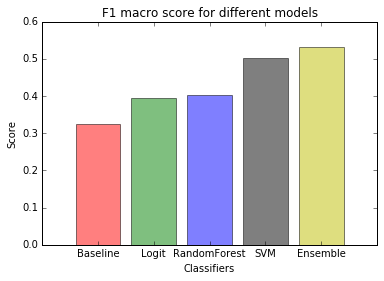

In [149]:
#Plot showing results of models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
scores = [baseline,score_logit,random_score,svc_score,ensemble_score]
models = ['Baseline','Logit','RandomForest','SVM','Ensemble']
y_pos=np.arange(len(scores))
my_colors = 'rgbkymc'
plt.bar(y_pos,scores, alpha=0.5,align='center',color=my_colors)
plt.xticks(y_pos,models)
plt.ylabel('Score');
plt.xlabel('Classifiers')
plt.title('F1 macro score for different models')
plt.show()